In [1]:
# import packages
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os
from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
import scipy.integrate as spi
import scipy.stats as st
from array import *
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import scipy.io as io
import math
import random
import pickle
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline

from ipynb.fs.full.All_Functions import GetPopParams
from ipynb.fs.full.All_Functions import GetPopParamsOmega
from ipynb.fs.full.All_Functions import GetVLIndParams
from ipynb.fs.full.All_Functions import RandVLIndParams
from ipynb.fs.full.All_Functions import RandVLParams
from ipynb.fs.full.All_Functions import ParamsPrep
from ipynb.fs.full.All_Functions import PKPDParams
from ipynb.fs.full.All_Functions import Cohort_Prep
from ipynb.fs.full.All_Functions import VLModel
from ipynb.fs.full.All_Functions import VLPKPD
from ipynb.fs.full.All_Functions import PK_Model
from ipynb.fs.full.All_Functions import PD_Model
#from ipynb.fs.full.All_Functions import SetInit
from ipynb.fs.full.All_Functions import SimulateTreatment
from ipynb.fs.full.All_Functions import Trial_Simulation
from ipynb.fs.full.All_Functions import Trial_Simulation_paramInput
from ipynb.fs.full.All_Functions import SimulateTreatmentPK
from ipynb.fs.full.All_Functions import TreatmentImpact
from ipynb.fs.full.All_Functions import CI_Calc
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/NBA_1510infections_7BroadVariants.csv'
Data_df = pd.read_csv(data_file)
Data_unVacc = Data_df[(Data_df.cat_VaccStatus!='Boosted')*(Data_df.cat_VaccStatus!='Second dose')*(Data_df.cat_VaccStatus!='First dose') ]
Data_unVacc_symp = Data_unVacc[Data_unVacc.cat_SympEver != 'No']
IDs_Symp = Data_unVacc_symp.ID.unique()
print(len(Data_unVacc_symp.ID.unique()))
Olddata_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/NBA_1510infections_AppendNegatives.csv'
OldData_df = pd.read_csv(Olddata_file)
OldData_unVacc = OldData_df[(OldData_df.cat_VaccStatus!='Boosted')*(OldData_df.cat_VaccStatus!='Second dose')*(OldData_df.cat_VaccStatus!='First dose') ]


IDs_unVacc = Data_unVacc.ID.unique()
OldIDs_unVacc = OldData_unVacc.ID.unique()


DeltaCases = Data_unVacc[Data_unVacc.cat_Lineage7variants == 'Delta']

ID_Delta = DeltaCases.ID.unique()
#print(len(ID_Delta))
IndParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/getModes_Run004/IndividualParameters/estimatedIndividualParameters.txt'
PopParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/getModes_Run004/populationParameters.txt'

parameters_df = pd.read_csv(IndParameters)
Popparameters_df = pd.read_csv(PopParameters)

Popparameters_U_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/NIRpopulationParameters(2).txt'

Popparameters_PK = pd.read_csv(Popparameters_U_file)

560


In [4]:
param_order = ['beta', 'phi', 'rho', 'k', 'delta', 'm', 'pi', 'c', 'tau']
fixed_params = dict({'c': 15, 'r':10, 'k':4})
param_dist = dict({'log10beta':'normal', 'log10phi':'normal', 'log10rho':'normal', 
                   'delta':'logNormal', 'h': 'logNormal', 'm': 'logNormal', 
                   'log10pi':'normal','tau': 'logNormal', 'tzero':'logitNormal',
                   'tzeromin': 0.75, 'tzeromax':20})

Incubation_params = []
Variance = ['Historic', 'Alpha', 'Gamma', 'Delta', 'Omicron', 'Total']
Mean = [4.61, 4.96, 5.18, 4.43, 3.61, 4.54, 4.54]
SD = [2.24, 2.32, 2.72, 2.19, 1.82, 2.25]

for var, mean, sd in zip(Variance, Mean, SD):
    Incubation_params.append({'VOC': var, 'Mean': mean, 'sd': sd})

Incubation_params = pd.DataFrame(Incubation_params)
Incubation_params[Incubation_params.VOC == 'Historic'].Mean

0    4.61
Name: Mean, dtype: float64

In [5]:
# Nirmatrelvir in vitro IC50
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
MolMass = 499.5   #g/Mol


In [6]:
def SetInit(param_dict):
    T_0 = 10**7
    R_0 = 0;
    E_0 = 0;
    I_0 = 0
    V_0 = param_dict['Vzero']
    #param_dict['pi']*I_0/param_dict['c']
    return [T_0, R_0, E_0, I_0, V_0]

In [7]:
def Incubation_Prep(Data_unVacc_symp, Incubation_params, Cohort, TrtmntStrtDay, params, 
                        PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                       TreatmentLength = 5, TreatmentFrequency = 0.5):
    for idi, ID, tstart, in zip(range(0,len(Cohort)), Cohort, TrtmntStrtDay):

            tzero_est = param_dict[idi]['tzero']
            tau_est = param_dict[idi]['tau']
            if Data_unVacc_symp[Data_unVacc_symp.ID == ID].cat_Lineage7variants.unique()[0]=='None':
                Lineage = 'Total'
                shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean
            else:
                Lineage = Data_unVacc_symp[Data_unVacc_symp.ID==ID].cat_Lineage7variants.unique()[0]
                shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean

            incub = np.random.gamma(shape, scale)

            params[idi][-1] = params[idi][-1]+(tzero_est-incub[0])
            param_dict[idi]['tzero']=incub[0]
            param_dict[idi]['tau']=params[idi][-1]
            t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                          PKPDInd[idi], param_dict[idi], 
                                                          PotRed[idi], MolMass, 0, SetInit, VLPKPD,
                                   TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
            T,R,E,I,V, Ag, A1, A2 = y.T
            v = np.log10(np.maximum(V,10**2))
            v[v==2]=1
            Tmax_index = np.argwhere(v==max(v))[0][0]
            Tmax = t[Tmax_index]

            PS_Duration = t[np.where((v == 1) & (t>Tmax))]

            while (len(PS_Duration) != 0 and PS_Duration[0]<5):
                params[idi][-1] = tau_est
                param_dict[idi]['tzero']=tzero_est
                param_dict[idi]['tau']=tau_est

                incub = np.random.gamma(shape, scale)

                params[idi][-1] = params[idi][-1]+(tzero_est-incub[0])
                param_dict[idi]['tzero']=incub[0]
                param_dict[idi]['tau']=params[idi][-1]

                t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                          PKPDInd[idi], param_dict[idi], 
                                                          PotRed[idi], MolMass, 0, SetInit, VLPKPD,
                                   TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
                T,R,E,I,V, Ag, A1, A2 = y.T
                v = np.log10(np.maximum(V,10**2))
                v[v==2]=1
                Tmax_index = np.argwhere(v==max(v))[0][0]
                Tmax = t[Tmax_index]
                PS_Duration = t[np.where((v == 1) & (t>Tmax))]
    
    return params, param_dict

In [8]:
    
def Trial_Simulation_paramInput(TrtmntStrtDay, params, 
                                PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = 5, TreatmentFrequency = 0.5):
        # import parameters
        # extract initial time
        t0 = -param_dict['tzero']
        # extract onset of symptoms from data
       # t_symp = filtered.SympOnsetDelay[filtered.ID == ID]
  #      TrtmntStrtDay = random.choice(range(0,4)) #treatment starting within 3 days of synptom onset
        t_end = 30 #duration of simulation 30 days after symptom onset. 
        #TrtmntStrtDay+14 # the duration of simulation (14 days after the start of treatment)
        init = SetInit(param_dict)
        init.extend([0,0,0])
        
        dosetimes = TrtmntStrtDay + np.arange(0,TreatmentLength,TreatmentFrequency)
     #   print(dosetimes[0])
     #   if (t0 > t_symp.values[0]):
      #      n=n+1
      #      continue
        t,y = SimulateTreatment(VLPKPD, init, t0, 0.001, t_end, params, PKPDInd, dose, dosetimes, PotRed, MolMass)
        return t, y, dosetimes

In [9]:
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
prf = [73, 61, 61, 61, 61, 65, 57, 61, 61, 65] # prf values that maximized R2 for 10 runs (fig2c)
MolMass = 499.5 
Num = 400
Cohort = Cohort_Prep(IDs_Symp, Num)
CohortStyle = 'direct'
dose = 0

v_all = []
t_all = []
I_all = []
R_all = []
S_all = []
TrtmntStrtDay_all = []
print(TrtmntStrtDay_all)

PotRed=np.random.normal(np.mean(prf), np.std(prf), Num)
VLparams, PKPD_params, param_dict = ParamsPrep(Cohort, CohortStyle, GetVLIndParams, 
                                               RandVLParams, parameters_df, Popparameters_df, 
                                               fixed_params, param_order, param_dist, PKPDParams, 
                                               Popparameters_PK, GetPopParams, GetPopParamsOmega, 
                                               Emax, IC50, Hill,PDOm, dose)
#VLparams, param_dict = Incubation_Prep(Data_unVacc_symp, Incubation_params, Cohort,np.ones(Num), VLparams, 
#                                       PKPD_params, param_dict, PotRed, MolMass, 0, SetInit, VLPKPD,
#                                       TreatmentLength = 5, TreatmentFrequency = 0.5)


for timing in ['Control', 'day 1', 'day 4', 'day 7', 'day 10']:
    print(timing)
    v = []
    s = []
    i = []
    r = []
    times = []
    if timing == 'Control':
        dose =0
    else:
        dose = 300
    TrtmntStrtDay = [1 for i in range(0,len(Cohort))]
    for idi in range(0, Num):
        if timing == 'day 1':
            TrtmntStrtDay [idi] =1-param_dict[idi]['tzero']
        elif timing == 'day 4':
            TrtmntStrtDay [idi] =4-param_dict[idi]['tzero']
        elif timing =='day 7':
            TrtmntStrtDay [idi] =7-param_dict[idi]['tzero']
        elif timing == 'day 10':
            TrtmntStrtDay [idi] =10-param_dict[idi]['tzero']

    for idi, tstart, in enumerate(TrtmntStrtDay):
    
        t, y, dosetimes = Trial_Simulation_paramInput(tstart, VLparams[idi][:], 
                                                    PKPD_params[idi], param_dict[idi], 
                                                    PotRed[idi], MolMass, dose, SetInit, VLPKPD,
                            TreatmentLength = 5, TreatmentFrequency = 0.5)
        T,R,E,I,V, Ag, A1, A2 = y.T
        v.append(np.log10(np.maximum(V,10**2)))
        v[idi][v[idi]==2]=1
        s.append(np.maximum(T, 1))
        i.append(np.maximum(I, 1))
        r.append(np.maximum(R, 1))
        times.append(t)
    v_all.append(v)
    I_all.append(i)
    R_all.append(r)
    S_all.append(s)
    t_all.append(times)
    TrtmntStrtDay_all.append(TrtmntStrtDay)

[]
Control
day 1
day 4
day 7
day 10


In [26]:
tzero = [d.get('tzero') for d in param_dict]
tlength = [len(t) for t in v_all[0]]
print(max(tlength))
t_tzero = np.linspace(0, max(tlength)/1000-0.001, max(tlength))
t_tzero

34075


array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 3.4072e+01, 3.4073e+01,
       3.4074e+01])

In [28]:
t_tzero[np.argwhere(t_tzero>=6)[0][0]]

6.000000000000002

In [11]:
param_dict[0]['phi']

1.0667926135936371e-07

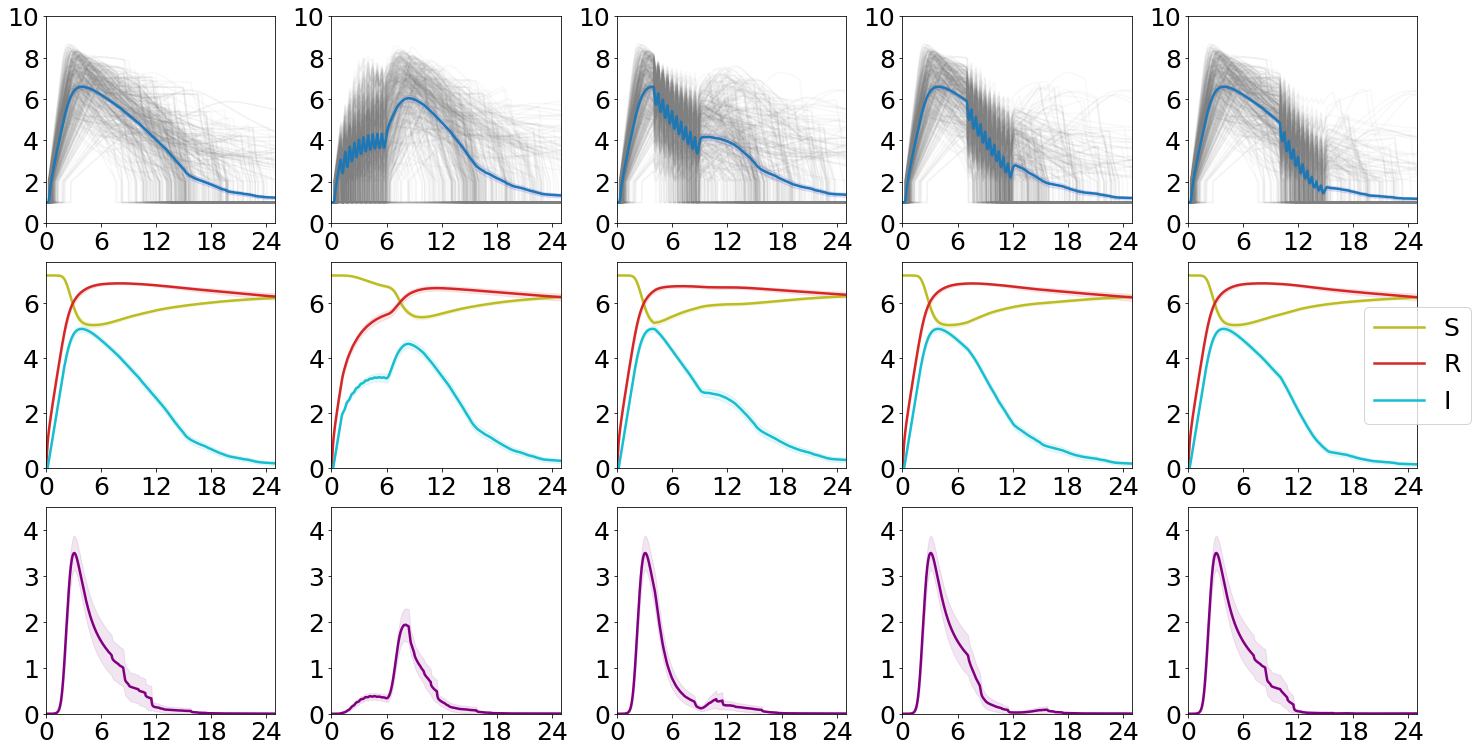

In [39]:
# plot a few examples
timing = ['Control', 'day 1', 'day 4', 'day 7', 'day 10']
fig = plt.figure(figsize = (22,11))
plt.rcParams.update({'font.size': 25})

for iii, (tt, V, S, I, R, TrtmntStrtDay) in enumerate(zip(t_all, v_all, S_all, I_all, R_all, TrtmntStrtDay_all)):
    VL = []
    Susc = []
    Inf = []
    Ref = []
    LateRes = []
    EarlyRes = []
    
    for j in range(0,Num):
        if len(V[j])<max(tlength):
            VL.append(np.hstack([V[j],(np.ones(max(tlength)-len(V[j])))]))
            Inf.append(np.log10(np.hstack([I[j],(np.ones(max(tlength)-len(I[j])))])))
            Ref.append(np.log10(np.hstack([R[j],(np.ones(max(tlength)-len(R[j])))])))
            Susc.append(np.log10(np.hstack([S[j],(np.ones(max(tlength)-len(S[j])))])))
            
        else:
            VL.append(V[j])
            Inf.append(np.log10(I[j]))
            Ref.append(np.log10(R[j]))
            Susc.append(np.log10(S[j]))
   #     lImm = np.zeros(max(tlength))
    #    indaLate = np.argwhere(t_tzero>=param_dict[j]['tAI']+tzero[j])
   #     lImm[indaLate] = param_dict[j]['m']
   #     LateRes.append(lImm)
        EarlyRes.append(param_dict[j]['phi']*np.hstack([I[j],(np.ones(max(tlength)-len(I[j])))]))
        plt.subplot(3,5,1+iii)
        plt.plot(t_tzero, VL[j], color = 'grey', alpha = 0.05)
       # plt.subplot(4,5,1+iii+15)
       # plt.plot(t_tzero, I[j] ,color = 'grey', alpha = 0.05)
    VLmean = np.mean(VL, axis = 0)
    VLstd = np.std(VL, axis = 0)
  #  LateResMean = np.mean(LateRes, axis = 0)
  #  LateResstd = np.std(LateRes, axis = 0)
    Smean = np.mean(Susc, axis = 0)
    Sstd = np.std(Susc, axis = 0)
    Imean = np.mean(Inf, axis = 0)
    Istd = np.std(Inf, axis = 0)
    Rmean = np.mean(Ref, axis = 0)
    Rstd = np.std(Ref, axis = 0)
    EarlyResMean = np.mean(EarlyRes, axis = 0)
    EarlyResstd = np.std(EarlyRes, axis = 0)
    cVL = st.norm.interval(confidence=0.95, loc=VLmean, scale=VLstd/np.sqrt(Num))
    cI = st.norm.interval(confidence=0.95, loc=Imean, scale=Istd/np.sqrt(Num))
    cS = st.norm.interval(confidence=0.95, loc=Smean, scale=Sstd/np.sqrt(Num))
    cR = st.norm.interval(confidence=0.95, loc=Rmean, scale=Rstd/np.sqrt(Num))
 #   cLate = st.norm.interval(alpha=0.95, loc=LateResMean, scale=LateResstd/np.sqrt(Num))
    cEarly = st.norm.interval(confidence=0.95, loc=EarlyResMean, scale=EarlyResstd/np.sqrt(Num))
    
    plt.subplot(3,5,1+iii)
    plt.plot(t_tzero, VLmean, linewidth=2.5)
    plt.fill_between(t_tzero, cVL[0], cVL[1], color = 'blue', alpha = 0.1)
    #plt.title(str(timing[iii]))
   # if iii == 0:
   #     plt.ylabel('log10(VL)')
    plt.ylim([0.5,10])
    plt.xlim([0,25])
    plt.xticks([0,6,12,18,24])
    plt.yticks([0,2 ,4,6,8, 10])
    
    plt.subplot(3,5,1+iii+5)
    plt.plot(t_tzero, Smean, color = 'tab:olive', label = 'S', linewidth = 2.5)
    plt.fill_between(t_tzero, cS[0], cS[1], color = 'tab:olive', alpha = 0.1)
    plt.plot(t_tzero, Rmean, color = 'tab:red', label = 'R', linewidth = 2.5)
    plt.fill_between(t_tzero, cR[0], cR[1], color = 'tab:red', alpha = 0.1)
    plt.plot(t_tzero, Imean, color = 'tab:cyan', label = 'I', linewidth = 2.5)
    plt.fill_between(t_tzero, cI[0], cI[1], color = 'tab:cyan', alpha = 0.1)
    plt.xlim([0,25])
    plt.ylim([0,7.5])
    plt.xticks([0,6,12,18,24])
    plt.yticks([0,2,4,6])
   # if iii == 0:
       # plt.ylabel('log10(cell count)')
    if iii==4:
        plt.legend(bbox_to_anchor=(1, 0.5))
    plt.subplot(3,5,1+iii+10)
    plt.plot(t_tzero, EarlyResMean, color = 'purple',linewidth=2.5)
    plt.fill_between(t_tzero, cEarly[0], cEarly[1], color = 'purple', alpha = 0.1)
    plt.ylim([0,4.5])
    plt.yticks([0,1,2,3,4])
    plt.xlim([0.,25])
    plt.xticks([0,6,12,18,24])
   # if iii == 0:
    #    plt.ylabel('$\phi I$')
    
   # if iii == 2:
   #     plt.xlabel('time since infection (days)')
plt.tight_layout(w_pad=0.4, h_pad = 0.3)           
plt.savefig('/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Paxlovid Paper/PaperFigures/UpdatedFigures/ImmRes_CI_logCells.png')

6000
9000
12000
15000
end of treatment(days post infection)  arm      
6                                      Treatment    0.788369
                                       control     -1.571751
9                                      Treatment   -0.908314
                                       control     -1.242598
12                                     Treatment   -0.871904
                                       control     -1.015554
15                                     Treatment   -0.751390
                                       control     -0.836422
Name: log10(S/R), dtype: float64
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9_control vs. 9_Treatment: Mann-Whitney-Wilcoxon test two-sided, P_val:2.250e-13 U_stat=5.604e+04
6_control vs. 6_Treatment: Mann-Whitney-Wilcoxon test two-sided, P_val:5.116e-89 U_stat=1.463e+04
12_control vs. 12_Treatment: Ma

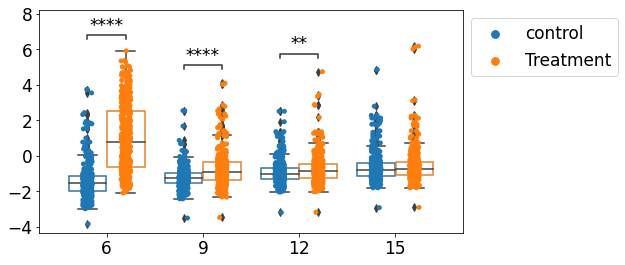

In [42]:
fig = plt.figure(figsize = (9,4))
plt.rcParams.update({'font.size': 17})
SR_Ratio = []
for day, S, R  in zip([6, 9, 12, 15],S_all[1:], R_all[1:]):
    Susc = []
    Ref = []
    dayindex = np.argwhere(t_tzero>=day)[0][0]
    print(dayindex)
    for j in range(0,Num):
        SR_Ratio.append({'end of treatment(days post infection)': day, 'arm': 'control', 
                         'log10(S/R)': np.log10(S_all[0][j][dayindex])-np.log10(R_all[0][j][dayindex])})
       
        SR_Ratio.append({'end of treatment(days post infection)': day, 'arm': 'Treatment',
                         'log10(S/R)': np.log10(S[j][dayindex])-np.log10(R[j][dayindex])})
       
SR_Ratio = pd.DataFrame(SR_Ratio)
#palette = ['tab:blue','tab:orange','tab:blue','tab:green','tab:blue', 'tab:red','tab:blue', 'tab:purple']
    
ax = sns.stripplot(x='end of treatment(days post infection)', y='log10(S/R)', data = SR_Ratio, hue='arm', dodge= True)
handles, labels = ax.get_legend_handles_labels()
ax = sns.boxplot(x='end of treatment(days post infection)', y='log10(S/R)', data = SR_Ratio, hue='arm', showmeans = True)
for p in ax.patches:
    mybox =p
    color = mybox.get_facecolor()
    mybox.set_facecolor((0, 0, 0, 0))
    mybox.set_edgecolor(color)
plt.legend([],[], frameon=False)
ax.legend(handles, labels,  bbox_to_anchor=(1, 1))
medians = SR_Ratio.groupby(['end of treatment(days post infection)', 'arm'])['log10(S/R)'].median()
print(medians)
#vertical_offset = medians * 0.05 # offset from median for display

  #  ax.set_xticks(range(1,9), labels=['Control', 'PEP', 'Control','Early Trtmnt', 'Control', 'Trial', 'Control', 'Late Trtmnt'])
#pairs = [[('PEP', 'control'),('PEP', 'Treatment')] ,[('Early','control'), ('Early', 'Treatment')], 
            # [('Intermediate','Control'), ('Intermediate','Treatment')], [('Late','Control'), ('Late','Treatment')]]

#annotator = Annotator(ax, pairs, data=VL, x='Timing of Therapy', y='log10(VL)', hue='arm')
#annotator.configure(test = 'Mann-Whitney').apply_and_annotate()
pairs = [[(6, 'control'),(6, 'Treatment')] ,[(9,'control'), (9, 'Treatment')], 
             [(12,'control'), (12,'Treatment')]]

annotator = Annotator(ax, pairs, data=SR_Ratio, x='end of treatment(days post infection)', y='log10(S/R)', hue='arm')
annotator.configure(test = 'Mann-Whitney').apply_and_annotate()
plt.ylabel('')
plt.xlabel('')
plt.yticks([-4,-2,0,2,4,6,8])
plt.tight_layout()      
plt.savefig('/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Paxlovid Paper/PaperFigures/UpdatedFigures/SR.png')

end of treatment(days post infection)  arm      
6                                      Treatment    0.068167
                                       control      0.521727
9                                      Treatment    0.011641
                                       control      0.064424
12                                     Treatment    0.000447
                                       control      0.003715
15                                     Treatment    0.000032
                                       control      0.000149
Name: $\phi I$, dtype: float64
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9_control vs. 9_Treatment: Mann-Whitney-Wilcoxon test two-sided, P_val:1.947e-18 U_stat=1.086e+05
6_control vs. 6_Treatment: Mann-Whitney-Wilcoxon test two-sided, P_val:2.964e-35 U_stat=1.205e+05
12_control vs. 12_Treatment: Mann-Whitney-Wilcoxon test

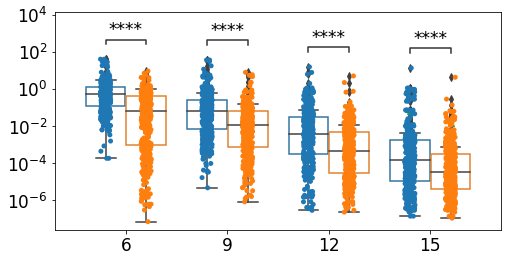

In [32]:
fig = plt.figure(figsize = (8,4))
plt.rcParams.update({'font.size': 17})
EarlyRes = []
for day, I  in zip([6, 9, 12, 15],I_all[1:]):
    Susc = []
    Ref = []
    dayindex = np.argwhere(t_tzero>=day)[0][0]
 
    for j in range(0,Num):
        EarlyRes.append({'end of treatment(days post infection)': day, 'arm': 'control', '$\phi I$': (param_dict[j]['phi']*I_all[0][j][dayindex])})

        EarlyRes.append({'end of treatment(days post infection)': day, 'arm': 'Treatment', '$\phi I$': (param_dict[j]['phi']*I[j][dayindex])})

EarlyRes = pd.DataFrame(EarlyRes)
#palette = ['tab:blue','tab:orange','tab:blue','tab:green','tab:blue', 'tab:red','tab:blue', 'tab:purple']
    
ax = sns.stripplot(x='end of treatment(days post infection)', y='$\phi I$', data = EarlyRes, hue='arm', dodge= True)
handles, labels = ax.get_legend_handles_labels()
ax = sns.boxplot(x='end of treatment(days post infection)', y='$\phi I$', data = EarlyRes, hue='arm', showmeans = True)
for p in ax.patches:
    mybox =p
    color = mybox.get_facecolor()
    mybox.set_facecolor((0, 0, 0, 0))
    mybox.set_edgecolor(color)
plt.legend([],[], frameon=False)
#ax.legend(handles, labels, bbox_to_anchor=(0.9, 1))
medians = EarlyRes.groupby(['end of treatment(days post infection)', 'arm'])['$\phi I$'].median()
print(medians)
#vertical_offset = medians * 0.05 # offset from median for display

  #  ax.set_xticks(range(1,9), labels=['Control', 'PEP', 'Control','Early Trtmnt', 'Control', 'Trial', 'Control', 'Late Trtmnt'])
#pairs = [[('PEP', 'control'),('PEP', 'Treatment')] ,[('Early','control'), ('Early', 'Treatment')], 
            # [('Intermediate','Control'), ('Intermediate','Treatment')], [('Late','Control'), ('Late','Treatment')]]

#annotator = Annotator(ax, pairs, data=VL, x='Timing of Therapy', y='log10(VL)', hue='arm')
#annotator.configure(test = 'Mann-Whitney').apply_and_annotate()
pairs = [[(6, 'control'),(6, 'Treatment')] ,[(9,'control'), (9, 'Treatment')], 
             [(12,'control'), (12,'Treatment')], [(15,'control'), (15,'Treatment')]]
ax.set_yscale("log")
plt.yticks([0.000001,0.0001,0.01,1,100,10000])
annotator = Annotator(ax, pairs, data=EarlyRes, x='end of treatment(days post infection)', y='$\phi I$', hue='arm')
annotator.configure(test = 'Mann-Whitney').apply_and_annotate()
plt.ylabel('')
plt.xlabel('')
plt.savefig('/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Paxlovid Paper/PaperFigures/UpdatedFigures/phiI.png')